In [82]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVR

In [83]:
import pandas as pd
import random
from faker import Faker

fake = Faker()
Faker.seed(42)
random.seed(42)

# Sample CPT codes and denial reasons
cpt_codes = ['99213', '99214', '93000', '87070', '71020', '20550', '90471', '36415']
insurance_companies = ['UnitedHealthcare', 'Aetna', 'Cigna', 'BlueCross', 'Humana', 'Kaiser Permanente']
denial_reasons = ['Missing information', 'Charge exceeds fee schedule', 'Non-covered service']

# Generate fake data
data = []
for _ in range(1000):  # Generate 1000 rows
    cpt = random.choice(cpt_codes)
    insurer = random.choice(insurance_companies)
    physician = fake.name()
    
    results = random.choices([1, 0], weights=[0.3, 0.7])[0]  # 30% denial rate
    
    if results:
        payment = 0
        balance = random.randint(80, 300)
        denial_reason = random.choice(denial_reasons)
    else:
        payment = random.randint(80, 300)
        balance = 0
        denial_reason = None
    
    data.append({
        'CPT Code': cpt,
        'Insurance Company': insurer,
        'Physician Name': physician,
        'Payment Amount': payment,
        'Balance': balance,
        'Denial Reason': denial_reason,
    })

# Convert to DataFrame
AF_DATA = pd.DataFrame(data)

# Save to Excel
AF_DATA.to_excel('rcm_data.xlsx', index=False)
print("Fake RCM data saved to 'fake_rcm_data.xlsx'")


Fake RCM data saved to 'fake_rcm_data.xlsx'


In [84]:
# Define rule for denial with reversed labels (1 = Paid, 0 = Denied)
def define_denial(row):
    if pd.isnull(row['Payment Amount']) or row['Payment Amount'] == 0:
        return 'Denied'  # Denied
    else:
        return 'Paid'  # Paid

AF_DATA['results'] = AF_DATA.apply(define_denial, axis=1)


In [85]:
AF_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CPT Code           1000 non-null   object
 1   Insurance Company  1000 non-null   object
 2   Physician Name     1000 non-null   object
 3   Payment Amount     1000 non-null   int64 
 4   Balance            1000 non-null   int64 
 5   Denial Reason      299 non-null    object
 6   results            1000 non-null   object
dtypes: int64(2), object(5)
memory usage: 54.8+ KB


In [86]:
AF_DATA.isnull().sum()

CPT Code               0
Insurance Company      0
Physician Name         0
Payment Amount         0
Balance                0
Denial Reason        701
results                0
dtype: int64

In [87]:
AF_DATA['Denial Reason'] = AF_DATA['Denial Reason'].replace("None", "No Denial")
AF_DATA['Denial Reason'].fillna("No Denial", inplace=True)



C:\Users\Admin\AppData\Local\Temp\ipykernel_151104\666529537.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  AF_DATA['Denial Reason'].fillna("No Denial", inplace=True)


In [88]:
AF_DATA = pd.DataFrame(AF_DATA)
AF_DATA.to_csv('C:/Users/Admin/Desktop/Tensaw AR project/AR_DATA.csv',index=False)
AF_DATA

,CPT Code,Insurance Company,Physician Name,Payment Amount,Balance,Denial Reason,results
0,99214,UnitedHealthcare,Allison Hill,142,0,No Denial,Paid
1,87070,Aetna,Noah Rhodes,253,0,No Denial,Paid
2,99214,Humana,Angie Henderson,87,0,No Denial,Paid
3,99214,Aetna,Daniel Wagner,0,234,Missing information,Denied
4,87070,Kaiser Permanente,Cristian Santos,219,0,No Denial,Paid
...,...,...,...,...,...,...,...
995,99213,UnitedHealthcare,Brittany Ward,249,0,No Denial,Paid
996,93000,Cigna,Edward Stanley,192,0,No Denial,Paid
997,71020,Kaiser Permanente,Christina Johnson,0,288,Charge exceeds fee schedule,Denied
998,93000,UnitedHealthcare,Edgar Miller,196,0,No Denial,Paid


C:\Users\Admin\AppData\Local\Temp\ipykernel_151104\989829996.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([AF_DATA[col].dropna() for col in columns_to_check], labels=columns_to_check)


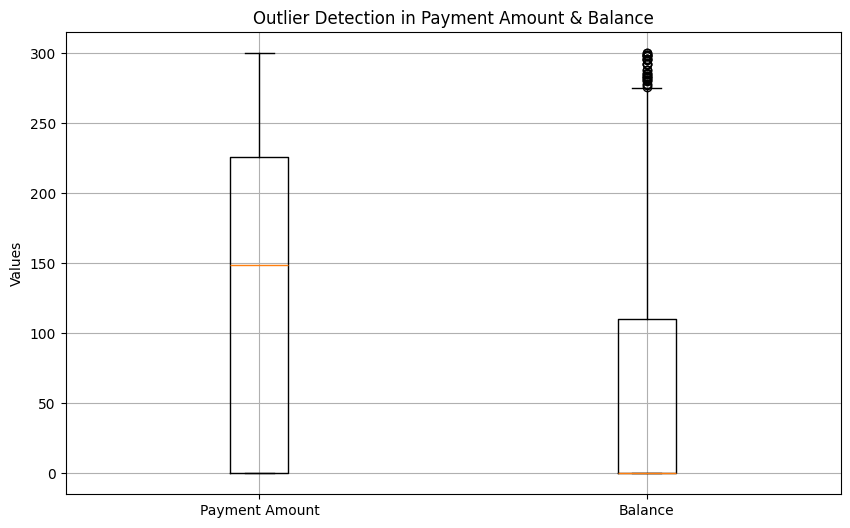

In [89]:
import matplotlib.pyplot as plt

# Outlier detection and visualization for Payment Amount and Balance
columns_to_check = ['Payment Amount', 'Balance']

plt.figure(figsize=(10, 6))
plt.boxplot([AF_DATA[col].dropna() for col in columns_to_check], labels=columns_to_check)
plt.title('Outlier Detection in Payment Amount & Balance')
plt.ylabel('Values')
plt.grid(True)
plt.show()


In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Compute Q1, Q3, and IQR
Q1 = AF_DATA['Balance'].quantile(0.25)
Q3 = AF_DATA['Balance'].quantile(0.75)
IQR = Q3 - Q1

# Define adaptive lower and upper bounds based on data spread
lower_bound = Q1 - 2.0 * IQR  # Increased strictness
upper_bound = Q3 + 2.0 * IQR

# Apply stricter IQR filtering first
AF_DATA_cleaned = AF_DATA[(AF_DATA['Balance'] >= lower_bound) & (AF_DATA['Balance'] <= upper_bound)]

# Apply Z-score filtering (removing extreme outliers beyond 2.5 standard deviations)
AF_DATA_cleaned = AF_DATA_cleaned[np.abs(zscore(AF_DATA_cleaned['Balance'])) < 2.5]

# Apply Log Transformation to normalize data (use np.log1p to handle zero values)
AF_DATA_cleaned['Balance'] = np.log1p(AF_DATA_cleaned['Balance'])

# Winsorization: Cap extreme values instead of full removal
AF_DATA_cleaned['Balance'] = np.clip(AF_DATA_cleaned['Balance'], lower_bound, upper_bound)

# Save cleaned dataset
AF_DATA_cleaned.to_csv('AF_DATA_cleaned_final.csv', index=False)


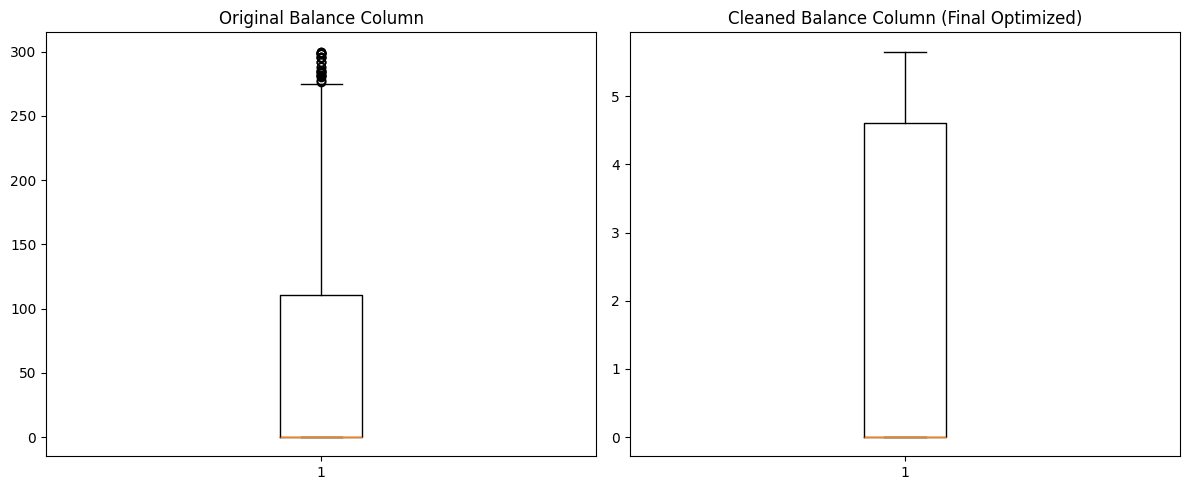

Original dataset size: 1000
Cleaned dataset size: 983
Final optimized outlier removal successfully applied!


In [91]:
# Boxplot comparison to verify further outlier removal
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.boxplot(AF_DATA['Balance'].dropna())
plt.title('Original Balance Column')

plt.subplot(1, 2, 2)
plt.boxplot(AF_DATA_cleaned['Balance'].dropna())
plt.title('Cleaned Balance Column (Final Optimized)')

plt.tight_layout()
plt.show()

# Print summary statistics before and after
print(f"Original dataset size: {AF_DATA.shape[0]}")
print(f"Cleaned dataset size: {AF_DATA_cleaned.shape[0]}")
print("Final optimized outlier removal successfully applied!")


In [92]:
print("Final dataset summary:")
print(AF_DATA_cleaned['Balance'].describe())

Final dataset summary:
count    983.000000
mean       1.472499
std        2.330611
min        0.000000
25%        0.000000
50%        0.000000
75%        4.615121
max        5.655992
Name: Balance, dtype: float64


In [93]:
from sklearn.preprocessing import LabelEncoder
import pickle

# Initialize dictionary to store encoders
label_encoders = {}

# List of columns to encode
columns_to_encode = ['Insurance Company', 'Physician Name', 'Denial Reason', 'results']

# Apply LabelEncoder
for col in columns_to_encode:
    le = LabelEncoder()
    AF_DATA_cleaned[col] = le.fit_transform(AF_DATA_cleaned[col].astype(str))
    label_encoders[col] = le

# Save encoders to a pickle file
with open('pickle\\label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

print("Encoding complete and encoders saved.")
print(AF_DATA_cleaned.head())


Encoding complete and encoders saved.
  CPT Code  Insurance Company  Physician Name  Payment Amount   Balance  \
0    99214                  5              23             142  0.000000   
1    87070                  0             734             253  0.000000   
2    99214                  3              61              87  0.000000   
3    99214                  0             226               0  5.459586   
4    87070                  4             197             219  0.000000   

   Denial Reason  results  
0              2        1  
1              2        1  
2              2        1  
3              1        0  
4              2        1  


In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score




# Load processed data
df = AF_DATA_cleaned

# Step 1: Define features and target
X = df.drop(['results'], axis=1)
y = df['results']

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Scale numerical features (optional for tree-based models, but required for SVM, Logistic)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'KNN Classifier': KNeighborsClassifier()
}

# Loop through models and evaluate each one
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

   
    y_pred = model.predict(X_test_scaled)

    
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"{model_name}:")
    print ("Confusion Matrix : \n", cm)
    print ("Accuracy : ", accuracy_score(y_test, y_pred)*100)

Logistic Regression:
Confusion Matrix : 
 [[ 46   0]
 [  0 151]]
Accuracy :  100.0
Random Forest:
Confusion Matrix : 
 [[ 46   0]
 [  0 151]]
Accuracy :  100.0
Gradient Boosting:
Confusion Matrix : 
 [[ 46   0]
 [  0 151]]
Accuracy :  100.0
XGBoost:
Confusion Matrix : 
 [[ 46   0]
 [  0 151]]
Accuracy :  100.0
KNN Classifier:
Confusion Matrix : 
 [[ 46   0]
 [  0 151]]
Accuracy :  100.0


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [95]:
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('C:/Users/Admin/Desktop/Tensaw AR project/AF_DATA_cleaned.csv')

label_encoder_columns = ["Insurance Company", "Physician Name", "Denial Reason"]

for col in label_encoder_columns:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    le.fit(df[col])
    with open(f'pickle/label_encoder_{col}.pkl', 'wb') as f:
        pickle.dump(le, f)  # ✅ Save the full encoder object


In [96]:
with open('pickle\\XGBClassifier.pkl', 'wb') as file:
    pickle.dump(model, file)
with open('pickle\\GradientBoostingClassifier.pkl', 'wb') as file:
    pickle.dump(model, file)
with open('pickle\\LogisticRegression.pkl', 'wb') as file:
    pickle.dump(model, file)

with open('pickle\\scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)